# Keypoint regression with heatmaps in fastai v2

*This post is also available as [a Jupyter notebook in my website's repository](https://github.com/ElteHupkes/eltehupkes.github.io/blob/gh-pages/_notebooks/2021-03-10-keypoint-regression-fastai.ipynb)*

A common task in computer vision is finding points of interest in images. For instance, think about locating the position of facial features or joint positions, or locating a set of keys in a picture of your living room (I'm not aware of anybody having built this, but they should). There's a [tutorial in the fastai documentation](https://docs.fast.ai/tutorial.vision.html#Points) showing a quick way to create a keypoint regressor using a convolutional neural net. The way this works is simple: take a pretrained network, and slap a linear layer at the end that predicts $(x,y)$ coordinates for the number of points that you're interested in.

While this approach may have decent results, you might find that the average error can really be quite bad. The reason for this [can be found in the literature](https://arxiv.org/abs/1411.5752) and is intuitively understood as follows: a deep convolutional neural net will generally learn more semantically complex features as it gets deeper into the network, but it will lose spatial accuracy. What that means is that the early layers will be able to activate on simple geometries (i.e. "vertical line") whereas the later layers activate on more complex concepts composed of these geometries (i.e. "fur" or "foot"). If you are training a classifier, having semantically rich features is necessary and sufficient for the task ("human foot" plus "knee" plus "chest" equals high probability of the class "person"), but for precise localization of specific points in the input image, a higher resolution is typically required. For accurate prediction we do however also need the broader context (locating a knee will be much more accurate if we can takethe position of a foot into account), so we cannot simply use fewer and simpler layers. The challenge then becomes to create network that can predict semantically rich features without losing spatial accuracy.

Several approaches have been developed to combat this problem, an good overview in the field of human pose estimation can be foun [in this post](https://nanonets.com/blog/human-pose-estimation-2d-guide/). A common approach is to not predict points directly, but rather predict a _heat map_ of point locations for each point of interest. For instance, let's assume we want to predict the nose and eyes in a `256x256` picture of a face, the output of our network will be a $3xWxH$ tensor, with each channel respresenting one of our points of interest, and each pixel representing the likelihood of that pixel being the location we're looking for. To retrieve the output pixel value, we simply find the pixel with the highest activation in each output heat map, and scale its coordinate back up to the original. As prediction targets we generate $3xWxH$ reference images that are filled with mostly zeroes, but have Gaussian kernels centered around the location of the keypoints. The use of Gaussian kernels introduces a wider range of "correct" answers and makes it less likely that the model will have a better score by simply predicting all zeros.

With that, our task has suddenly become a lot like another task: semantic segmentation. Indeed, similar U-Net style networks have been successfully employed for this task. In this blog post I will be looking at how we can achieve this heat map regression using vanilla fastai v2. 

As a bonus I'm going look into reducing the rounding error by implementing [Heatmap Regression via Randomized Rounding](https://arxiv.org/abs/2009.00225), something I'll do using a [HRNet](https://arxiv.org/pdf/1902.09212.pdf) architecture - a state of the art architecture when it comes to human pose estimation.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Some debugging convenience. If you use trace() in a loop,
# you can turn it off temporarily using trace_off()
from IPython.core.debugger import set_trace
_set_trace = set_trace
set_trace = set_trace
def enable_trace(enable=True):
    global _set_trace, set_trace
    set_trace = _set_trace if enable else lambda: 1

def trace_off(): enable_trace(False)
def trace_on(): enable_trace(True)

I originally ran this on Google Colab, where I needed to upgrade fastai to version 2:

In [38]:
# On Colab, make sure to run this to install fastai2 if the default is still v1.
# Upgrade to fastai2
# !pip install --upgrade fastai

# Data
I'll be using the [LaPa](https://github.com/JDAI-CV/lapa-dataset) dataset in this post. This dataset consists of 22000+ images of faces, with 106 facial landmarks annotated in each image. The dataset has already been split into training, validation and test sets. Let's start by downloading the dataset. There's a Google Drive link on the GitHub page of the dataset. Unfortunately Google Drive puts an annoying warning page in front of files larger than 25mb, so we can't create a direct file URL, but we can use a utility called `gdown` to download the file for us (use `!pip install gdown` if it hasn't been installed already). Let's download and extract the dataset (it's 2.4Gb, so have some patience and disk space):

In [4]:
# LaPa
import gdown
lapa='https://drive.google.com/uc?id=1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG'
gdown.download(lapa, 'lapa.tgz', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG
To: /content/lapa.tgz
2.37GB [00:49, 47.5MB/s]


'lapa.tgz'

Now let's load fastai and import the dataset.

In [3]:
from fastai.vision.all import *
import os

In [6]:
file_extract('lapa.tgz')

In [4]:
lapa_path = Path('LaPa')
lapa_path.ls()

(#3) [Path('LaPa/test'),Path('LaPa/train'),Path('LaPa/val')]

There's a `test`, `train` and a `val` path, with each the same structure:

In [5]:
lapa_path.ls()[0].ls()

(#3) [Path('LaPa/test/labels'),Path('LaPa/test/landmarks'),Path('LaPa/test/images')]

For each file in `images`, there's a text file in `landmarks` that contains the annotated location of the facial landmarks. In addition there's a segmentation mask in `labels` - we want to ignore these, so we'll have to make sure to not load _all_ image files. The images have varying sizes, so we'll have to resize them. The landmark text files contain lists of `x,y` locations of features. This gives us enough information to create a `DataBlock`:

In [6]:
import random

# The input size we'll be using throughout this notebook
SIZE=(256,256)

def get_lapa_images(path, max_n=None):
    f = get_files(path, extensions=set(['.jpg']))
    return random.sample(f, max_n) if max_n and len(f) > max_n\
            else f

def lapa_y(f, lm_idx=None):
    base=os.path.splitext(os.path.basename(f))[0]
    landmarks=f.parents[1]/'landmarks'/(f'{base}.txt')
    with open(landmarks, 'r') as f:
        # The first line of each landmarks file indicates the
        # number of landmarks and can be skipped.
        points = [[float(x) for x in line.strip().split()]
                    for line in f.readlines()[1:]]
    
    points = tensor(points)
    
    if lm_idx:
        points = points[lm_idx, :]
    
    return points

dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=partial(get_lapa_images, max_n=5000),
    get_y=lapa_y,
    item_tfms=Resize(SIZE),
    # We're leaving "test" alone for now
    splitter=GrandparentSplitter(train_name='train', valid_name='val')
)

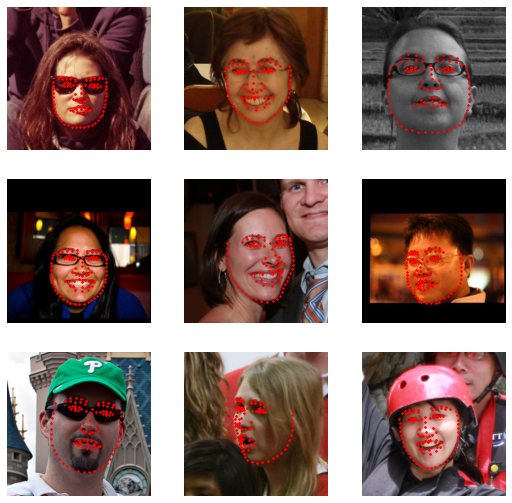

In [ ]:
dls = dblock.dataloaders(lapa_path)
dls.show_batch(max_n=9)

Looks good! To make things a bit easier in this post, I'm going to focus on 5 out of 106 facial landmarks. You may have noticed I'm also using just a fraction of the data just for the example to train more quickly later on. Let's redefine the datablock to limit the landmarks, and add some transforms in the process. We'll normalize with ImageNet stats, because we'll be using a model pretrained on ImageNet soon. The reason I'm not allowing the transform to flip images is that some of the annotated points on these faces are symmetric (well, maybe not the points I've selected, but in general), and I don't want to deal with mirrorred predictions.

In [7]:
USE_POINTS=[30, 40, 50, 60, 70]

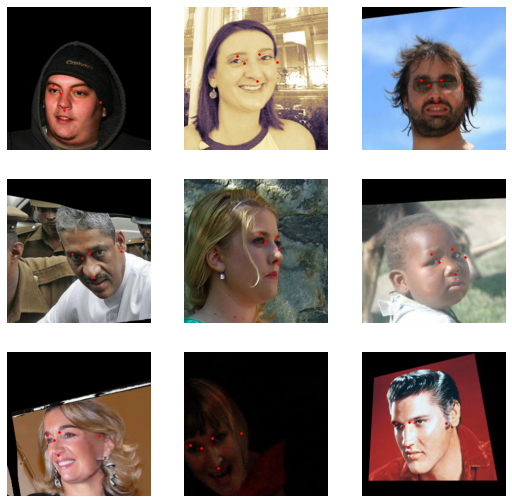

In [79]:
dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=partial(get_lapa_images, max_n=5000),
    get_y=partial(lapa_y, lm_idx=USE_POINTS),

    # Load individual items a bit bigger than the final size,
    # so that any warping / cropping transsforms have more room to work with.
    item_tfms=Resize(400),
    batch_tfms=[*aug_transforms(size=SIZE, do_flip=False), Normalize.from_stats(*imagenet_stats)],
    splitter=GrandparentSplitter(train_name='train', valid_name='val')
)

dls = dblock.dataloaders(lapa_path)
dls.show_batch(max_n=9)

That looks good. Now for the more interesting part.

## Gaussian Heatmaps

The first step to creating our heatmaps is creating a function that... well, generates a heat map. Let's define a function `generate_gaussian()` that takes a tensor and an `(x,y)` location, and generates a Gaussian kernel with a certain standard deviation at the given point. The credit for large parts of this code goes to one of the [repositories](https://github.com/leoxiaobin/deep-high-resolution-net.pytorch/blob/ba50a82dce412df97f088c572d86d7977753bf74/lib/dataset/JointsDataset.py#L242) of the HRNet model we'll use later on.



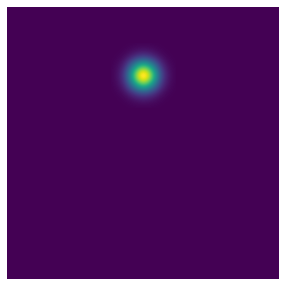

In [8]:
# A gaussian kernel cache, so we don't have to regenerate them every time.
# This is only a small optimization, generating the kernels is pretty fast.
_gaussians = {}

def generate_gaussian(t, x, y, sigma=10):
    """
    Generates a 2D Gaussian point at location x,y in tensor t.
    
    x should be in range (-1, 1) to match the output of fastai's PointScaler.
    
    sigma is the standard deviation of the generated 2D Gaussian.
    """
    h,w = t.shape
    
    # Heatmap pixel per output pixel
    mu_x = int(0.5 * (x + 1.) * w)
    mu_y = int(0.5 * (y + 1.) * h)
    
    tmp_size = sigma * 3
    
    # Top-left
    x1,y1 = int(mu_x - tmp_size), int(mu_y - tmp_size)
    
    # Bottom right
    x2, y2 = int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)
    if x1 >= w or y1 >= h or x2 < 0 or y2 < 0:
        return t
    
    size = 2 * tmp_size + 1
    tx = np.arange(0, size, 1, np.float32)
    ty = tx[:, np.newaxis]
    x0 = y0 = size // 2
    
    # The gaussian is not normalized, we want the center value to equal 1
    g = _gaussians[sigma] if sigma in _gaussians \
                else tensor(np.exp(- ((tx - x0) ** 2 + (ty - y0) ** 2) / (2 * sigma ** 2)))
    _gaussians[sigma] = g
    
    # Determine the bounds of the source gaussian
    g_x_min, g_x_max = max(0, -x1), min(x2, w) - x1
    g_y_min, g_y_max = max(0, -y1), min(y2, h) - y1
    
    # Image range
    img_x_min, img_x_max = max(0, x1), min(x2, w)
    img_y_min, img_y_max = max(0, y1), min(y2, h)
    
    t[img_y_min:img_y_max, img_x_min:img_x_max] = \
      g[g_y_min:g_y_max, g_x_min:g_x_max]
    
    return t

# Example:
show_image(generate_gaussian(torch.zeros(256, 256), 0, -0.5))

Alright, that's looking pretty good. Next, we need a way to actually _use_ these heatmaps. There are multiple approaches here. We could simply take our dataset, and create the heatmap stacks for each item in it. The advantage of this is that we'd have to create our heatmaps only once. There is a downside though: none of fastai's bundled data augmentation techniques work on our custom heatmaps, so we'd either have to reimplement those ourselves (which seems like a lot of work) or just not use them altogether (which doesn't seem all that great either). Instead, what if we implemented the heatmap as a `Transform`, and applied it at the end? That way, fastai's data augmentation techniques can go to town on the `TensorPoint` instances, and in the very last step we convert them to heatmaps for prediction. So that's what we're going to do below:

In [9]:
import itertools

# FastAIs `TensorPoint` class comes with a default `PointScaler` transform
# that scales the points to (-1, 1). This little function does the same
# given a point / tensor of points and original size.
def _scale(p, s): return 2 * (p / s) - 1

def heatmap2argmax(heatmap, scale=False):
    N, C, H, W = heatmap.shape
    index = heatmap.view(N,C,1,-1).argmax(dim=-1)
    pts = torch.cat([index%W, index//W], dim=2)
    
    if scale:
        scale = tensor([W,H], device=heatmap.device)
        pts = _scale(pts, scale)
    
    return pts

class Heatmap(TensorImageBase): 
    "Heatmap tensor, we can use the type to modify how we display things"
    pass

class HeatmapPoint(TensorPoint):
    """
    A class that mimics TensorPoint, but wraps it so
    we'll be able to override `show` methods with
    a different type.
    """
    pass

class HeatmapTransform(Transform):
    """
    A batch transform that turns TensorPoint instances into Heatmap instances,
    and Heatmap instances into HeatmapPoint instances.
    
    Used as the last transform after all other transformations. 
    """
    # We want the heat map transformation to happen last, so give it a high order value
    order=999
    
    def __init__(self, heatmap_size, sigma=10, **kwargs):
        """
        heatmap_size: Size of the heatmap to be created
        sigma: Standard deviation of the Gaussian kernel
        """
        super().__init__(**kwargs)
        self.sigma = sigma
        self.size = heatmap_size
    
    def encodes(self, x:TensorPoint):
        # The shape of x is (batch x n_points x 2)
        num_imgs = x.shape[0]
        num_points = x.shape[1]
        
        maps = Heatmap(torch.zeros(num_imgs, num_points, *self.size, device=x.device))
        for b,c in itertools.product(range(num_imgs), range(num_points)):
            # Note that our point is already scaled to (-1, 1) by PointScaler
            point = x[b][c]
            generate_gaussian(maps[b][c], point[0], point[1], sigma=self.sigma)
        
        return maps
    
    def decodes(self, x:Heatmap):
        """
        Decodes a heat map back into a set of points by finding
        the coordinates of their argmax.
        
        This returns a HeatmapPoint class rather than a TensorPoint
        class, so we can modify how we display the output.
        """
        # Flatten the points along the final axis,
        # and find the argmax per channel
        xy = heatmap2argmax(x, scale=True)
        return HeatmapPoint(xy, source_heatmap=x)

I should mention that generally, fastai will actually attempt to retain the specific subclass of the tensor after each transform. Since `Heatmap` cannot be downcasted to `TensorPoint` it comes out as itself just fine in this case; I consider the whole thing a bit of a hack though. Note also that these classes accept a flexible number of points, so we can let them create as many heat maps as we want.

Alright, let's see what it looks like if we use the exact same code as before, but now we add our `HeatmapTransform` at the end:

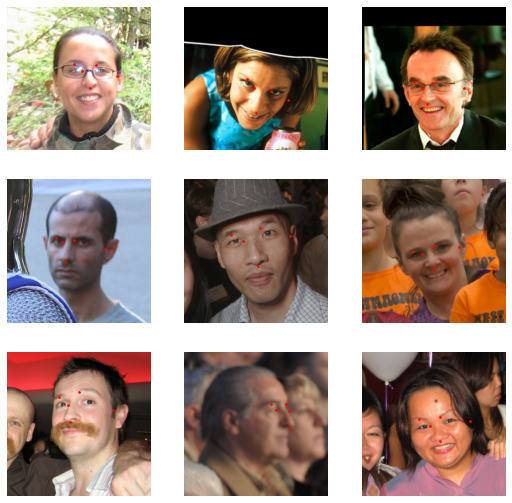

In [10]:
dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=partial(get_lapa_images, max_n=5000),
    get_y=partial(lapa_y, lm_idx=USE_POINTS),
    item_tfms=Resize(400),
    batch_tfms=[*aug_transforms(size=SIZE, do_flip=False), 
                Normalize.from_stats(*imagenet_stats),
                HeatmapTransform(heatmap_size=SIZE)],
    splitter=GrandparentSplitter(train_name='train', valid_name='val')
)

dls = dblock.dataloaders(lapa_path, bs=24)
dls.show_batch(max_n=9)

That looks... identical. This is good, because it means that our points are successfully converted to a heatmap and then back to the original point when they are displayed. It would be helpful to display our generated heat maps though, so we get an idea what's going on under the hood. We can change the way a batch of data is displayed by defining a `show_batch()` function which takes the custom types we've defined earlier. By adding the `@typedispatch` decorator, it essentially gets added to a list of functions with that name, and when the main `show_batch()` function is called it will invoke the one with a matching type. Let's override `show_batch()` for our `HeatmapPoint`s:

In [11]:
@typedispatch
def show_batch(x:TensorImage, y:HeatmapPoint, samples, ctxs=None, 
               max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    """
    Custom show_batch for a TensorImage / Heatmap pair, that shows
    the predicted points as well as the heat maps. Note that this method ignores
    nrows / ncols entirely.
    """
    # x is a list of TensorImages
    # y is a list of Heatmaps
    # samples is a list of (TensorImage, HeatmapPoint) tuples
    
    # Number of items to display
    n = min(len(samples), max_n)
    
    # Could also get this from the number of points
    n_heatmaps = y[0].shape[0]
    
    cols = 1 + n_heatmaps
    
    if ctxs is None:
        ctxs = get_grid(cols * n, nrows=n, ncols=cols, figsize=figsize)
    
    # Show the image overlaid with the points
    for ctx,sample,_ in zip(ctxs[0::cols], samples, range(n)):
        sample[0].show(ctx=ctx, **kwargs)
        sample[1].show(ctx=ctx, **kwargs)
    
    # Show the individual heatmaps
    heatmaps = y.source_heatmap
    for i in range(n_heatmaps):
        # I'd add the `y` to the `zip`, but it's upcasted
        # to a tensor when iterated (but not when indexed)
        ctxs[i+1::cols] = [heatmaps[j][i].show(ctx=ctx, cmap='viridis', vmin=0, vmax=1, **kwargs) 
                           for ctx,j in zip(ctxs[i+1::cols], range(n))]
    
    return ctxs

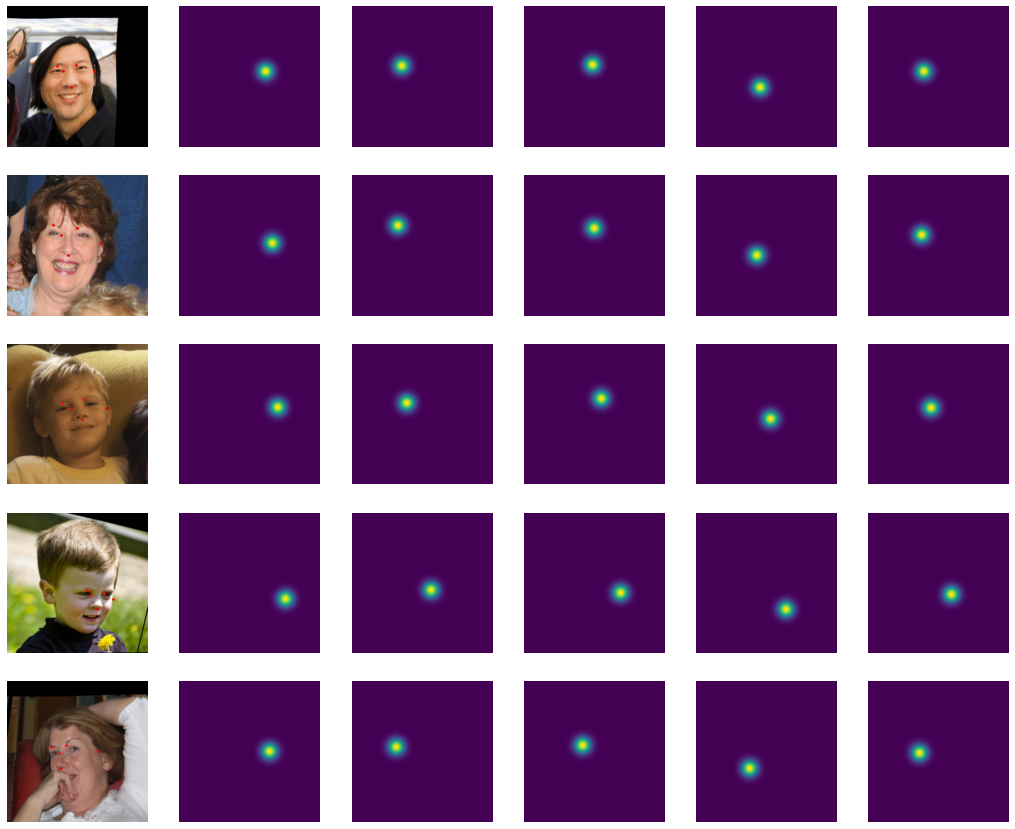

In [85]:
dls.show_batch(max_n=5)

I've chosen to display each heatmap separately here, which would obviously be a bit of an issue when predicting a large number of points. You could choose to merge the heatmaps instead or, if you want to keep insight in separate heatmap annotations / predictions, add a keyword argument that lets you display specific heatmaps. Or do both. Limitless possibilities. Moving on!

Ok great! With that out of the way, we can simply use standard fastai to train a "segmentation" model.

You might have noticed that the Gaussian kernels in these heatmaps are fairly large (i.e. they're created with a large standard deviation). I've done this on purpose for this article, because a bigger activation simply trains faster because of the steeper loss. It stands to reason that it reduces the prediction accuracy somewhat, but fiddling with this hyper parameter is beyond the scope of this article, because it seems boring and I don't want to 😉.

## Training a UNet
Before we create our learner, let's define the metric we want to show to evaluate our training and results. We'll use Normalized Mean Absolute Error, which is the percentual absolute error of each coordinate from its target. As a loss function we'll simply use Mean Squared Error.

In [12]:
def nmae_argmax(preds, targs):
    # Note that our function is passed two heat maps, which we'll have to
    # decode to get our points. Adding one and dividing by 2 puts us
    # in the range 0...1 so we don't have to rescale for our percentual change.
    preds = 0.5 * (TensorBase(heatmap2argmax(preds, scale=True)) + 1)
    targs = 0.5 * (TensorBase(heatmap2argmax(targs, scale=True)) + 1)
    
    return ((preds-targs).abs()).mean()

def gaussian_heatmap_loss(pred, targs):
    targs = TensorBase(targs)
    pred = TensorBase(pred)
    return F.mse_loss(pred, targs)

In [13]:
learn = unet_learner(dls, resnet18, n_out=len(USE_POINTS), 
                     loss_func=gaussian_heatmap_loss, 
                     metrics=[nmae_argmax])
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


DynamicUnet (Input shape: 24)
Layer (type)         Output Shape         Param #    Trainable 
                     24 x 64 x 128 x 128 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                     

Even a ResNet18 has over 31 million parameters (the "non-trainable" part is because fastai has initially frozen the pretrained layers). Let's have a look at the results that our untrained model produces:

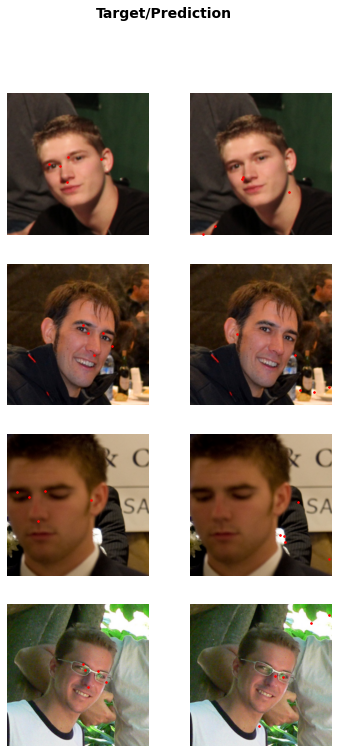

In [14]:
learn.show_results(max_n=4)

That's all over the place, as expected from an untrained model. An actual issue at this point is that we can't see what heatmaps our model has predicted. We can correct that by `@typedispatch` overriding another fastai function:

In [16]:
@typedispatch
def show_results(x:TensorImage, y:HeatmapPoint, samples, outs, ctxs=None, max_n=10, nrows=None, 
                 ncols=None, figsize=None, **kwargs):
    # x,y,samples are all reference (target) data, same as show_batch:
    # x is a list of TensorImages
    # y is a list of Heatmaps
    # samples is a list of (TensorImage, HeatmapPoint) tuples
    # outs contains a list of our predicted HeatmapPoint instances.
    
    # Number of items to display
    n = min(len(samples), max_n)
    
    # Could also get this from the number of points
    n_heatmaps = y[0].shape[0]
    
    # We're going to display the input image with target points,
    # the input image again with the predicted points, and
    # the predicted heat maps.
    cols = 2 + n_heatmaps
    
    if ctxs is None:
        ctxs = get_grid(cols * n, nrows=n, ncols=cols, figsize=figsize,
                       title='Target/Prediction/Heatmaps')
        
    # Show the target image overlaid with the points, and
    # the target image overlaid with the predicted points
    for tctx,pctx,sample,out,_ in zip(ctxs[0::cols], ctxs[1::cols], samples, outs, range(n)):
        sample[0].show(ctx=tctx, **kwargs)
        sample[1].show(ctx=tctx, **kwargs)
        sample[0].show(ctx=pctx, **kwargs)
        out[0].show(ctx=pctx, **kwargs)
    
    # Show the predicted heat maps
    # Note that each value in outs will contain all our source heatmaps,
    # because of the way fastai copies the metadata.
    heatmaps = outs[0][0].source_heatmap
    for i in range(n_heatmaps):
        # I'd add the heatmaps to the `zip`, but it's upcasted
        # to a tensor when iterated (but not when indexed)
        ctxs[i+2::cols] = [heatmaps[j][i].show(ctx=ctx, cmap='viridis', **kwargs) 
                           for ctx,j in zip(ctxs[i+2::cols], range(n))]
    
    return ctxs

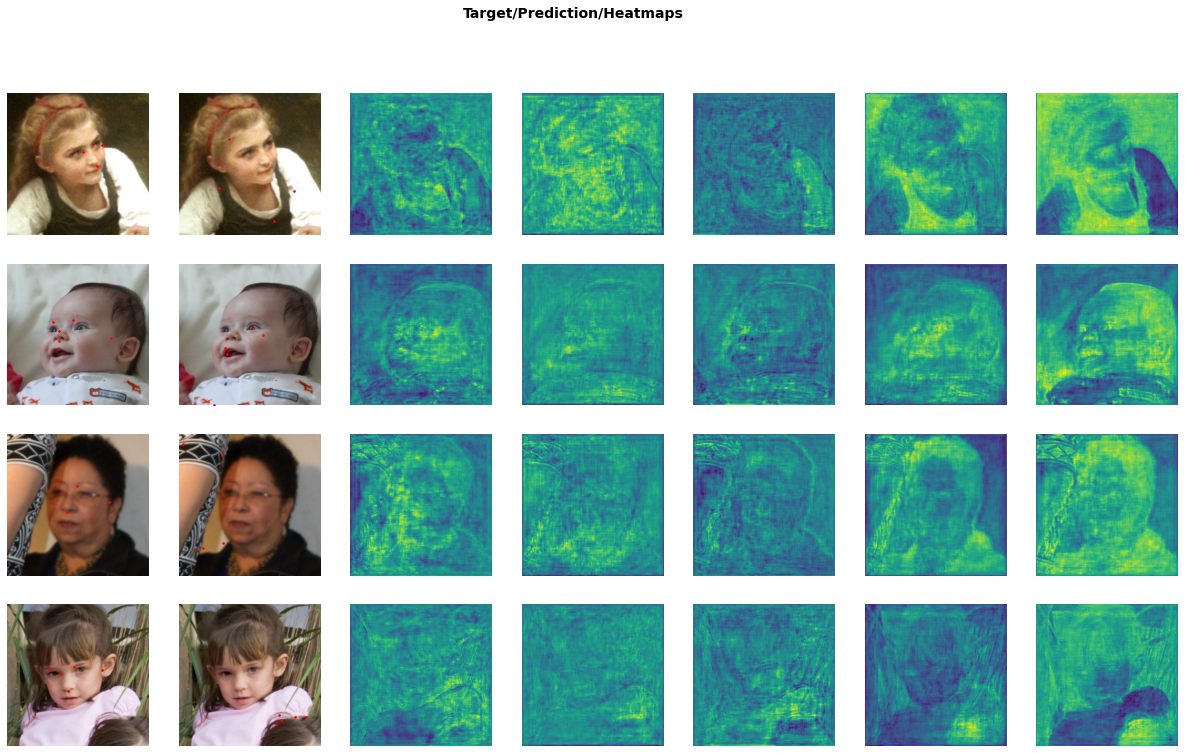

In [90]:
learn.show_results(max_n=4)

A word of warning: if you're going to override `show_batch()` and `show_results()` in a notebook, keep in mind that any changes to the displayed types (i.e. `HeatmapPoint` and `Heatmap` here) will override the types themselves, so you have to rerun the cells containing the `show_*` overrides in order for them to take effect to the new types. The same is true for the custom transforms. This has bitten me a couple of times, so I figured I'd issue a warning.

Anyway, we can now see our separate heatmaps (and see that they indeed are just semi-random shadows of the data), so let's train it!

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=1.2022644114040304e-05)

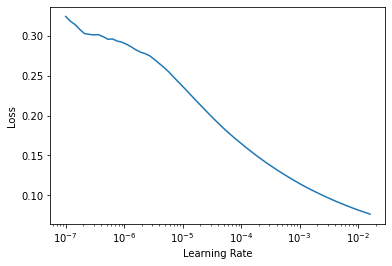

In [17]:
learn.lr_find()

In [18]:
learn.fine_tune(10, 8e-5)

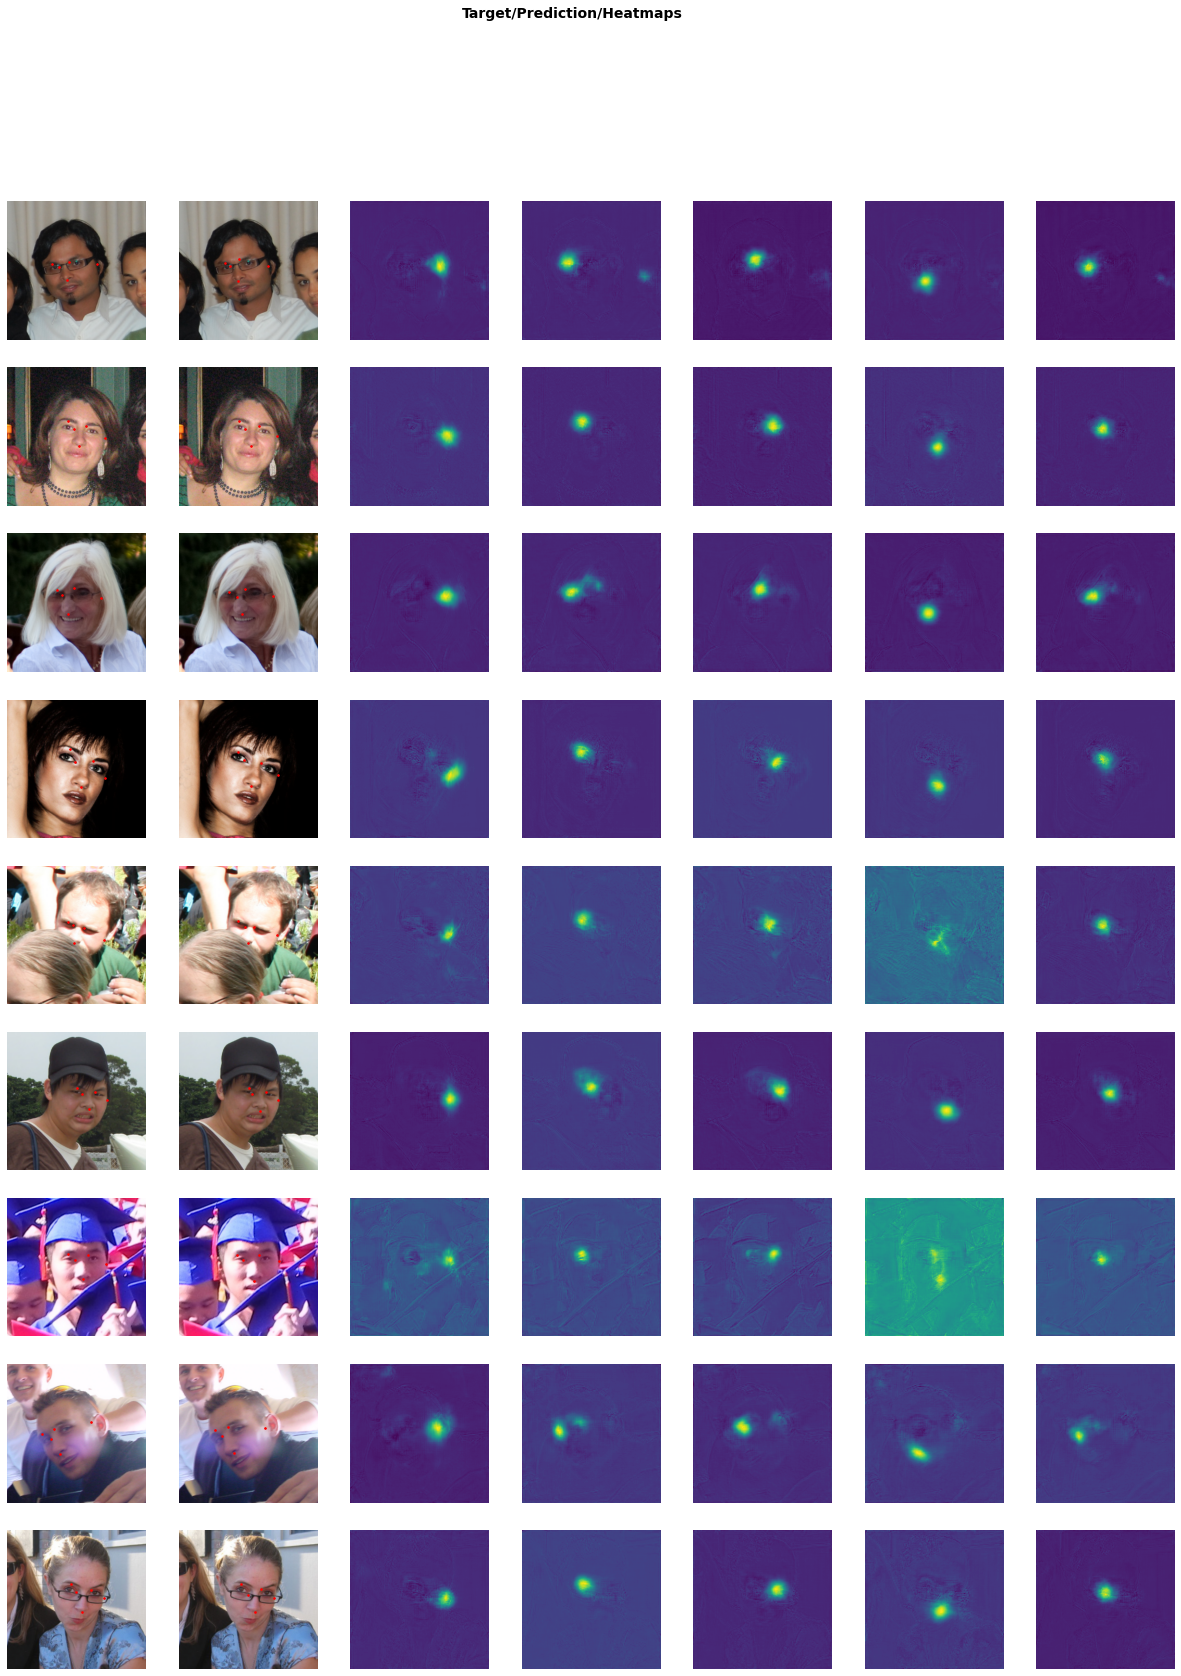

In [20]:
learn.show_results()

There's nothing special going on here that isn't discussed at length in the fastai docs, so I'm not going over the training process itself. What's important: it trains! These results aren't _fantastic_, but for the amount of training we did and the amount of data we used, it's actually pretty good. I'm sure with some fiddling (tweaking the size of the Gaussian kernel, for instance), more data and more training we could get a better result. The point here was mostly to show how to make something like this work, so I'll leave the fine tuning for when somebody leaves a GeForce RTX 3080 on my doorstep (in the box please, and make sure it's not raining. Actually just ring the bell, probably working from home anyway). Let's continue.

## Random Rounding and High-Resolution-Net
As promised, I'm now going to look at some techniques that can make all of this a bit better. To do that, I'm going to implement a part of [this paper](https://arxiv.org/abs/2009.00225), with a bit of help from the [associated GitHub repository](https://github.com/baoshengyu/H3R). At the time of this writing, that repo contains only inference code, so it'll be interesting to see if we can reproduce the training.

The problem that that this paper aims to tackle is that of coordinate rounding errors in the predicted heatmaps. The size of predicted heatmaps will typically be a lot smaller than that of the original image, and the smaller we can get them, the less computation power we'll need. Because of this, even if the model succeeds in predicting the exact integer pixel that an original keypoint was rounded to, scaled back to the original image it might still be quite a few pixels away from the actual target. For example, let's say our original pixel was `(1822, 412)` in a `2500x2500` image, and we have a heat map of size `64x64`. Given a perfect model, our predicted output coordinates will be:

In [19]:
round(1822/2500 * 64) * 2500/64, round(412/2500 * 64) * 2500/64

(1835.9375, 429.6875)

That's 14 and 18 pixels off in each respective direction! The paper suggests solving this problem by encoding the exact coordinate of the target pixel in the heatmap by randomly assigning it to one of the four candidates that result from rounding / truncating the floating point scaled coordinates. The probability with which each `x,y` coordinate is selected is proportional to how close it is to the unrounded point. In our example the unrounded heatmap point is `(46.6432, 10.5472)`, the x-coordinate to our point would be assigned to either `46` or `47`, the y-coordinate to `10` or `11`, and there would be a slight preference to the higher value in both cases. Here's a function I wrote that performs this random rounding:

In [21]:
def coord2heatmap(x, y, w, h, heatmap):
    """
    Inserts a coordinate (x,y) from a picture with 
    original size (w x h) into a heatmap, by randomly assigning 
    it to one of its nearest neighbor coordinates, with a probability
    proportional to the coordinate error.
    
    Arguments:
    x: x coordinate
    y: y coordinate
    w: original width of picture with x coordinate
    h: original height of picture with y coordinate
    """
    # Get scale
    oh,ow = heatmap.shape
    sx = ow / w
    sy = oh / h
    
    # Unrounded target points
    px = x * sx
    py = y * sy
    
    # Truncated coordinates
    nx,ny = int(px), int(py)
    
    # Coordinate error
    ex,ey = px - nx, py - ny
    
    xyr = torch.rand(2, device=heatmap.device)
    xx = (ex >= xyr[0]).long()
    yy = (ey >= xyr[1]).long()
    heatmap[min(ny + yy, heatmap.shape[0] - 1), 
            min(nx+xx, heatmap.shape[1] - 1)] = 1
    
    return heatmap

If this works as it should, the average of the `argmax` coordinates of all these heat maps should be the target coordinate. Let's try it out:

In [22]:
# Some random points
w,h=2500,1500
x,y=163,1342

# Size of our heatmap, not a square to rule out any
# sloppy errors.
ow,oh=256,384

# Expected output:
expected = (x*ow/w, y*oh/h)

# Generate 1000 heat maps
heatmaps = torch.stack([coord2heatmap(x,y,w,h, torch.zeros(oh,ow)) for _ in range(2000)])

# Get the coordinates of all the heatmaps
# and take the average per column.
coords = heatmap2argmax(heatmaps.unsqueeze(0)).squeeze(0).float()
avg = coords[:, 0].mean(),coords[:,1].mean()
avg = coords[:, 0].mean(),coords[:,1].mean()

avg, expected

((tensor(16.6730), tensor(343.5515)), (16.6912, 343.552))

Not _exactly_ the same, but they're close. Given enough of these random assignments over a lot of training samples, the hope is the model will learn to predict the relative contribution of each rounded point. To decode a heat map, the paper takes the top-N highest activations (N being a hyperparameter, set to 9 here), runs them through softmax, and multiplies the outputs with their coordinates to get the final coordinate. This way, the output coordinate will be a weighted average of multiple coordinates, and can be fractional, unlike in a standard heatmap approach. Since we're producing binary heatmaps in this approach and we need probability-like values, the model is trained using Cross Entropy Loss.

Let's implement a transform, similar to the previous `HeatmapTransform`, that turns a list of points into a "random binary heatmap". The decoding function [from the paper](https://github.com/baoshengyu/H3R/blob/master/torchalign/heatmap_head/transforms/functional.py) is used to turn the heatmap back into points:

In [23]:
def heatmap2coord(heatmap, topk=9):
    N, C, H, W = heatmap.shape
    score, index = heatmap.view(N,C,1,-1).topk(topk, dim=-1)
    coord = torch.cat([index%W, index//W], dim=2)
    return (coord*F.softmax(score, dim=-1)).sum(-1)

def topk_heatmap2coord(heatmap, topk=9, scale=False):
    coord = heatmap2coord(heatmap, topk)
    if scale:
        _, _, H, W = heatmap.shape
        scale = tensor([W,H], device=heatmap.device)
        coord = _scale(coord, scale)
    
    return coord

class RandomBinaryHeatmapTransform(Transform):
    order=999
    
    def __init__(self, heatmap_size, topk=9, **kwargs):
        super().__init__(**kwargs)
        self.size = tensor(heatmap_size)
        self.topk=topk
    
    def encodes(self, x:TensorPoint):
        # The shape of x is (batch x n_points x 2)
        num_imgs = x.shape[0]
        num_points = x.shape[1]
        
        maps = Heatmap(torch.zeros(num_imgs, num_points, *self.size, dtype=torch.long,
                                   device=x.device))
        for b,c in itertools.product(range(num_imgs), range(num_points)):
            heatmap = maps[b][c]
            
            # Note that our point is already scaled to (-1, 1) by PointScaler.
            # We pretend here it's in range 0...2
            point = x[b][c] + 1.
            coord2heatmap(point[0], point[1], 2., 2., heatmap)
        
        return maps
    
    def decodes(self, x:Heatmap):
        """
        Decodes a batch of binary heatmaps back into a set of
        TensorPoints.
        """
        if x.dtype == torch.long:
            # If the target heatmap is an annotation heatmap, our
            # decoding procedure is different - we need to directly
            # retrieve the argmax.
            return HeatmapPoint(heatmap2argmax(x, scale=True),
                               source_heatmap=x)
        
        return HeatmapPoint(topk_heatmap2coord(x, topk=self.topk, scale=True),
                           source_heatmap=x)

## High Resolution Net 

The second improvement we're looking at simultaneously is the model architecture. Our initial approach used a UNet-style model generated by fastai, based on a ResNet18 backbone, which overcomes the problem of the lack of spatial awareness by using an upsampling path. A more recent state of the art approach uses [HRNet](https://github.com/HRNet/HRNet-Semantic-Segmentation) (yes, that actually stands for "High Resolution Network"), which operates in a slightly different manner. Instead of having a downsampling path and an upsampling path, the model maintains a high resolution path at all times. Lower resolution paths are also created, but these paths all run alongside each other, and after each model "stage", upsampled / pooled versions of the outputs are exchanged and merged between them. The idea is that at each stage the model will have access to both higher level and lower leavel features to make its decicions. And, since it produced state of the art results, we'll have to assume it succeeded.

I won't claim to understand everything that's going on in this model, so I recommend you go to the GitHub repository I just linked (or rather the [collection of repositories](https://github.com/HRNet), they have a whole range of applications) and check out their code, papers and blog posts if you want to learn more. Here, I'm going to use the implementation used by the Randomized Rounding paper, because it's completely standalone and doesn't depend on any configuration files / formats. Let's download `hrnet.py` to the current directory:

In [19]:
download_url('https://raw.githubusercontent.com/baoshengyu/H3R/master/torchalign/backbone/hrnet.py', 'hrnet.py')

Simple enough, now we can import it (there are three versions in this file, this is the simplest one):

In [24]:
from hrnet import hrnet18

Let's construct one and run an imaginary image through it to see what it does. Note that there's a `pretrained` argument that can load in a pretrained model from the same repository (which won't work here since I pulled the file out of context). I'm not going to load these weights, because some of these models are already trained on LaPa, and that would likely take the fun out of training.

In [25]:
backbone = hrnet18().eval()
example = torch.rand(5, 3, 256, 256)
backbone(example).shape

torch.Size([5, 270, 64, 64])

For a `256 x 256` image, a `270 x 64 x 64` feature map is produced by this model. In order for it to be useful to us, we'll have to add a head on top of our backbone. This head is [also available in the repository]() but is small enough to include here - I've made only minor changes (most notably I'm not doubling the number of output channels).

In [26]:
class BinaryHeadBlock(nn.Module):
    def __init__(self, in_channels, proj_channels, out_channels, **kwargs):
        super(BinaryHeadBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, proj_channels, 1, bias=False),
            nn.BatchNorm2d(proj_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(proj_channels, out_channels, 1, bias=False),
        )
        
    def forward(self, input):
        return self.layers(input)

head = BinaryHeadBlock(270, 270, len(USE_POINTS))
nn.Sequential(backbone, head).eval()(example).shape

torch.Size([5, 5, 64, 64])

There's the output we need - 5 heatmaps of `64x64`, one for each feature. Those heatmaps are significantly smaller than our input images, but this is standard for HRNet, so we'll have to assume that it's a good idea or write our own paper justifying the use of more resources. We now have everything we need to create our new dataloaders and learner.

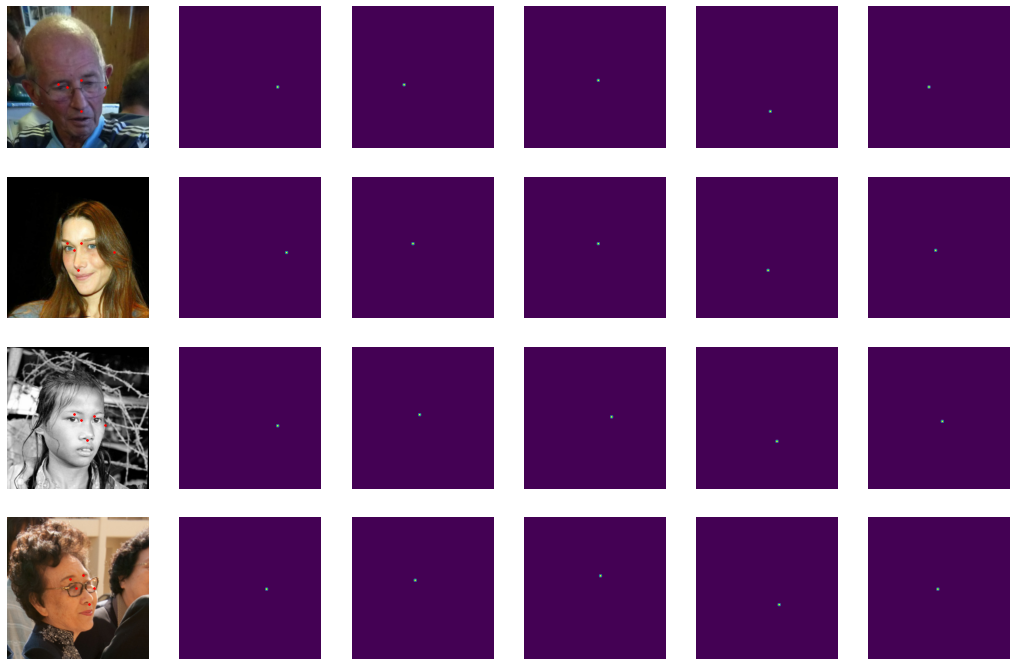

In [34]:
HM_SIZE=(64, 64)

dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=partial(get_lapa_images, max_n=5000),
    get_y=partial(lapa_y, lm_idx=USE_POINTS),
    item_tfms=Resize(400),
    batch_tfms=[*aug_transforms(size=SIZE, do_flip=False), 
                Normalize.from_stats(*imagenet_stats),
                RandomBinaryHeatmapTransform(heatmap_size=HM_SIZE)],
    splitter=GrandparentSplitter(train_name='train', valid_name='val')
)

dls = dblock.dataloaders(lapa_path)
dls.show_batch(max_n=4)

As a loss function, we're using binary cross entropy with logits. The code of the Randomized Rounding paper appears to output two planes for every landmark, implying that Cross Entropy Loss is being used instead. It seems to me that this would do more work than it needs to though, given that there really are only two classes.

In [28]:
def binary_heatmap_loss(preds, targs, pos_weight=None, topk=9):
    preds = TensorBase(preds)
    targs = TensorBase(targs).float()
    
    if pos_weight is not None:
        _,p,h,w=preds.shape
        pos_weight=torch.tensor(pos_weight, device=preds.device).expand(p, h, w)
    
    return F.binary_cross_entropy_with_logits(preds, targs, pos_weight=pos_weight)    

We add a `pos_weight` parameter to account for the class imbalance in the data (lots of black pixels, only one white pixel). This is the same `pos_weight` as `torch.nn.BCEWithLogitsLoss`, but PyTorch expects a weight for each prediction i.e. each pixel in each heatmap. Since all of these classes are actually the same, I just take a single float tensor and expand it over all items (`expand()` makes it so that the `pos_weight` tensor really only uses that one float in memory).

In [35]:
backbone = hrnet18()
head = BinaryHeadBlock(270, 270, len(USE_POINTS))
model = nn.Sequential(backbone, head)

def nmae_topk(preds, targs, topk=9):
    # Note that our function is passed two heat maps, which we'll have to
    # decode to get our points. Adding one and dividing by 2 puts us
    # in the range 0...1 so we don't have to rescale for our percentual change.
    preds = 0.5 * (TensorBase(topk_heatmap2coord(preds, topk=topk, scale=True)) + 1)
    targs = 0.5 * (TensorBase(heatmap2argmax(targs, scale=True)) + 1)
    
    return ((preds-targs).abs()).mean()

learn = Learner(dls, model, loss_func=partial(binary_heatmap_loss, pos_weight=100), metrics=[nmae_topk])
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 128 x 128 
Conv2d                                    1728       True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 64 x 64 x 64   
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 64 x 64  
Conv2d                                    16384    

Something to note here: this model has fewer than 10M parameters, so less than a third of the relatively shallow ResNet we used earlier. Let's show some untrained output:

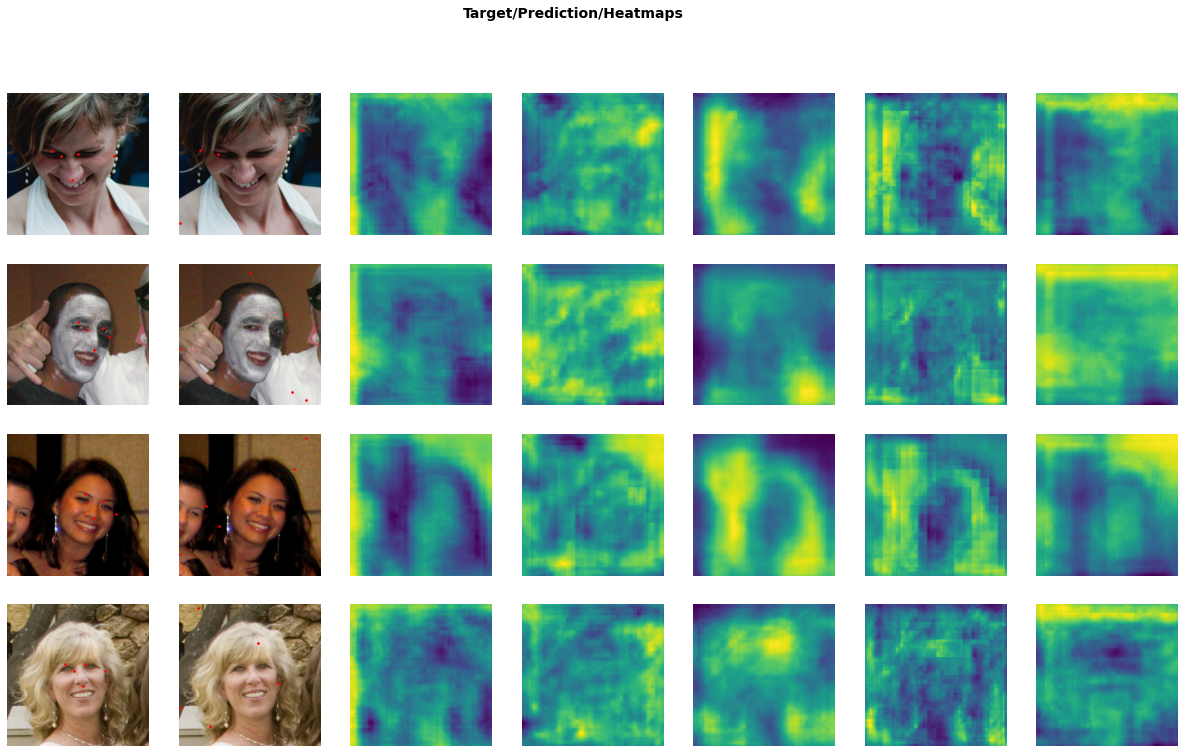

In [30]:
learn.show_results(max_n=4)

Be aware that the output heatmaps can be a bit misleading, because we either apply a sigmoid (for the loss) or softmax over the top-N values (for inference) before doing anything with them, whereas on display the values are just scaled linearly. Nevertheless they are a good indication of what is going on.

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.005248074419796467)

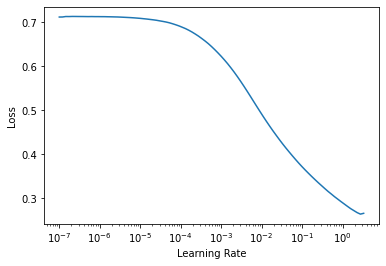

In [31]:
learn.lr_find()

In [36]:
learn.fit_one_cycle(10, 5e-3)

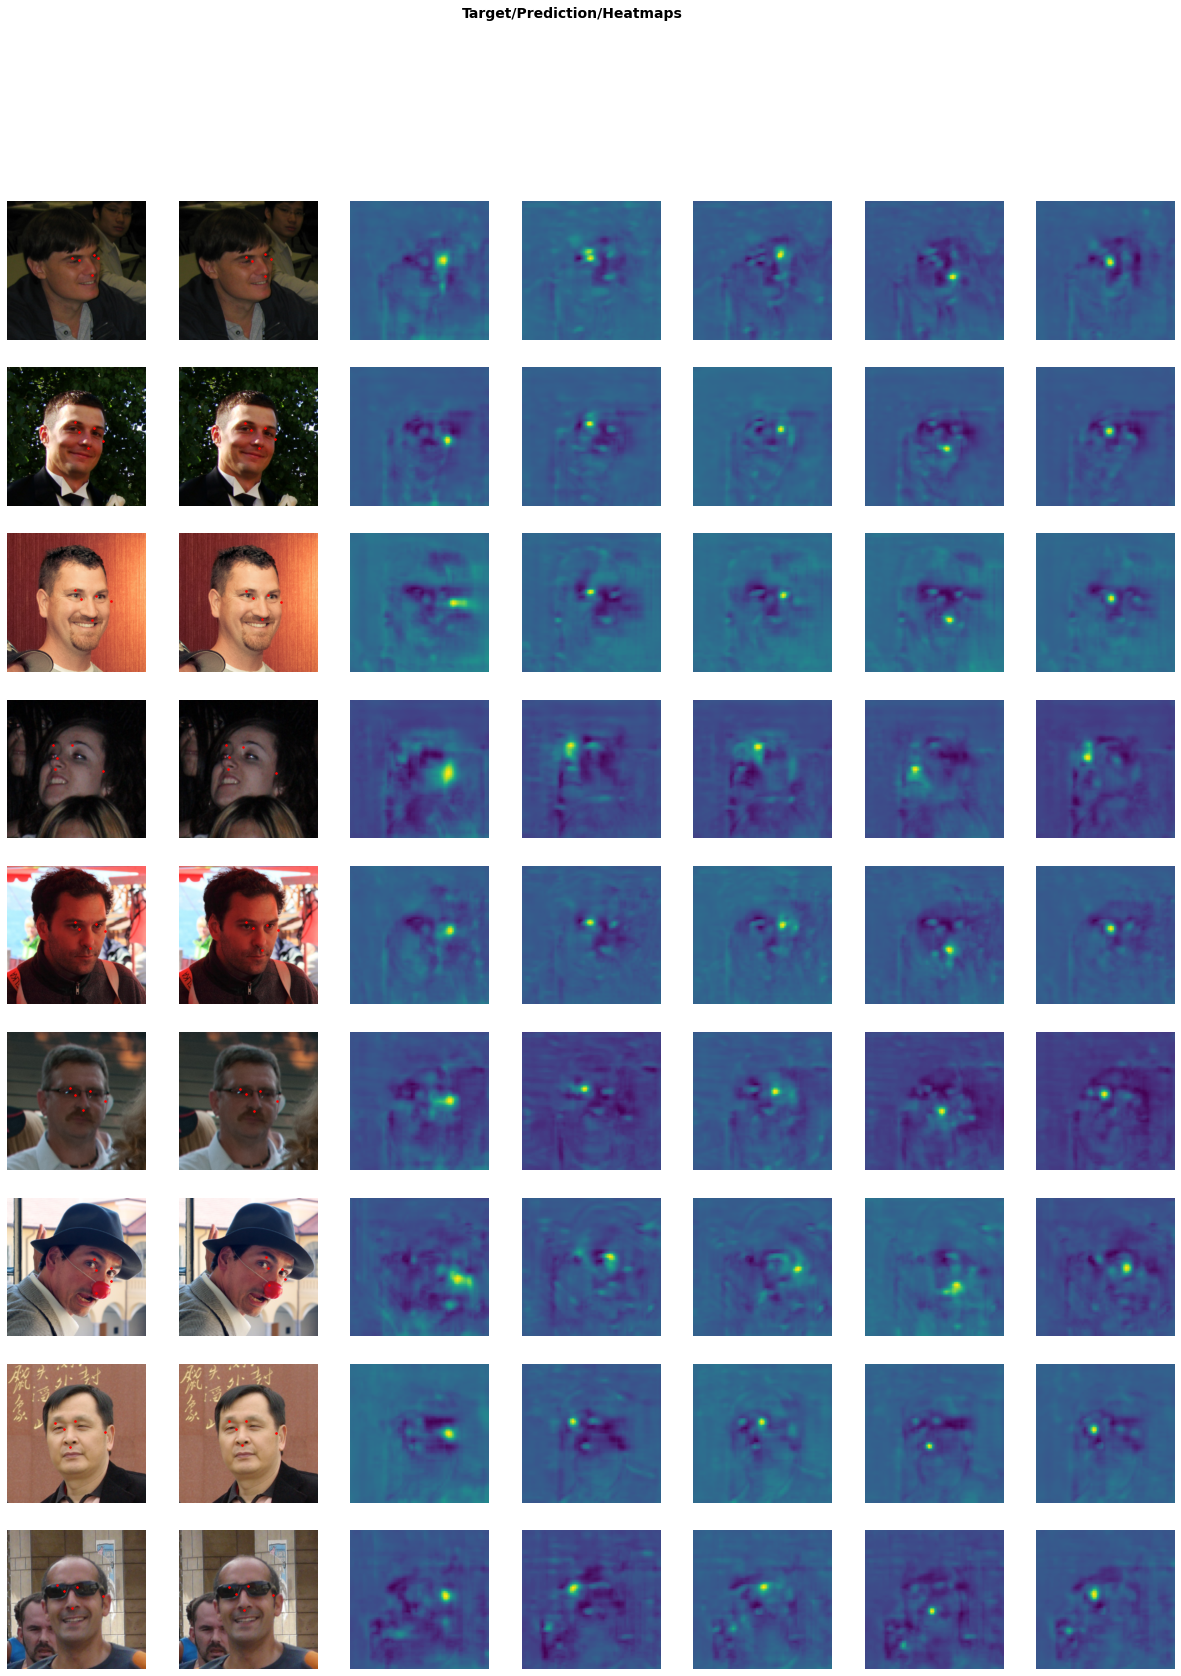

In [37]:
learn.show_results()

That's pretty good! Not only does it train quite a bit faster than our ResNet, the average error is much lower too - and don't forget we started from completely random weights, rather than our pretrained ResNet. Fewer parameters, better performance, faster training? Shut up and take my money!

## Conclusion
I hope I've given a bit of an overview here on how to improve landmark / keypoint regression models, and how to implement some of these techniques in fastai. I had no real prior experience with HRNet or heatmap regression before writing this article, so it's been an interesting exploration for me. HRNet and the Randomized Rounding technique are very promising. I can think of a few other ways in which the fractional pixel could be encoded: for instance, instead of random point assignment, we could actually encode the relative error in the intensity of the surrounding pixels, and train that with Mean Squared Error. I've not experimented with this, although I did write a function that does the encoding, it can be found [in a GitHub issue that discusses the encoder of the Randomized Rounding paper](https://github.com/baoshengyu/H3R/issues/6).

So as always, working with a novel machine learning technique raises at least as many questions as it answers; but I learned a lot of useful things doing it, and I can only hope those reading this did so as well.